In [16]:
from expansion_tools.blob_expansion_tools_jetset import *
from expansion_tools.delay_analysis import gamma_radio_delay_analysis_vs_freq,plot_lcs,gamma_radio_delay_analysis_vs_v_exp,plot_lcs_single_panel
from jetset.data_loader import Data,ObsData
from jetset.plot_sedfit import PlotSED


## Notebook to reproduce Section 4 of the paper

In [17]:
sed_data = ObsData(data_table=Data.from_file('sed_mrk421_mjd_56302.ecsv'))
from jetset.model_manager import  FitModel
fit_model=FitModel.load_model('processing/fit_model_lsb_mjd56302.pkl')

In [18]:
rest_frame='obs'
delta_t_out=1E3
t_exp=1E7

## expansion short

In [19]:
from jetset.jet_timedep import JetTimeEvol
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')
R0=temp_ev_acc_flare.rad_region.jet.parameters.R.val

def delta_t_est(t_exp,R0,beta_exp):
    return t_exp+R0/(beta_exp*3E10)

def t_dec_est(R0,a,beta_exp):
    return ((R0+beta_exp*3E10)*np.power(beta_exp*3E10,a))




In [20]:
def updage_fig(fig):
    for ax in fig.axes:
        try:
            ax.ticklabel_format(axis='y', style='sci')
            ax.yaxis.major.formatter._useMathText = True
        except:
            print('ticklabel_format failed')
            pass
        
        ax.legend( loc='best', ncol=1,fontsize=15)
        ax.xaxis.label.set_size(15)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.label.set_size(15)
        ax.yaxis.set_tick_params(labelsize=15)

In [21]:
def update_sed_plot(p):
    p.sedplot.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1,fontsize=15)
    p.sedplot.xaxis.label.set_size(15)
    p.sedplot.xaxis.set_tick_params(labelsize=15)

    p.secaxy.xaxis.label.set_size(15)
    p.secaxy.xaxis.set_tick_params(labelsize=15)

    p.sedplot.yaxis.label.set_size(15)
    p.sedplot.yaxis.set_tick_params(labelsize=15)
    p.fig.tight_layout()

In [22]:
def update_lc_plot(fig):
    for ax in fig.axes:
        ax.ticklabel_format(axis='y', style='sci')
        ax.yaxis.major.formatter._useMathText = True
        
        ax.legend( loc='best', ncol=1,fontsize=15)
        ax.xaxis.label.set_size(15)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.label.set_size(15)
        ax.yaxis.set_tick_params(labelsize=15)
        
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    fig.tight_layout()

Set `run=False` if you have already run the simulations, and you want only to regenerate lcs or SEDs

In [23]:

beta_exp=[0.1]
run=False
t_exp=1E7


for ID,v in enumerate(beta_exp):
    duration=delta_t_est(t_exp,R0,v)+10*t_dec_est(R0,-1,v)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,v)/86400))
    print('t_dec  est. %e (d)'%(t_dec_est(R0,-1,v)/86400))
    print('delay  est. %e (s)'%(delta_t_est(t_exp,R0,v)))
    print('t_dec  est. %e (s)'%(t_dec_est(R0,-1,v)))
    print('duration %e'%duration)
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(None,
                      fit_model,
                      'temp_ev_sim_exp_vs_no_exp',
                      temp_ev_acc_flare,
                      flare_duration=0,
                      average=None,
                      duration=duration,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      t_exp=t_exp)
    
   
    print('----------------------------------------------')

ID 0
beta_exp 0.100000
delta_t  est. 1.350309e+02 (d)
t_dec  est. 1.929014e+01 (d)
delay  est. 1.166667e+07 (s)
t_dec  est. 1.666668e+06 (s)
duration 2.833334e+07
T_SIZE 28333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
----------------------------------------------


In [24]:
NUM_SET

5000

In [25]:
temp_ev_expansion=JetTimeEvol.load_model('temp_ev_sim_exp_vs_no_exp/temp_ev_expansion_beta_exp=0.100.pkl')
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')

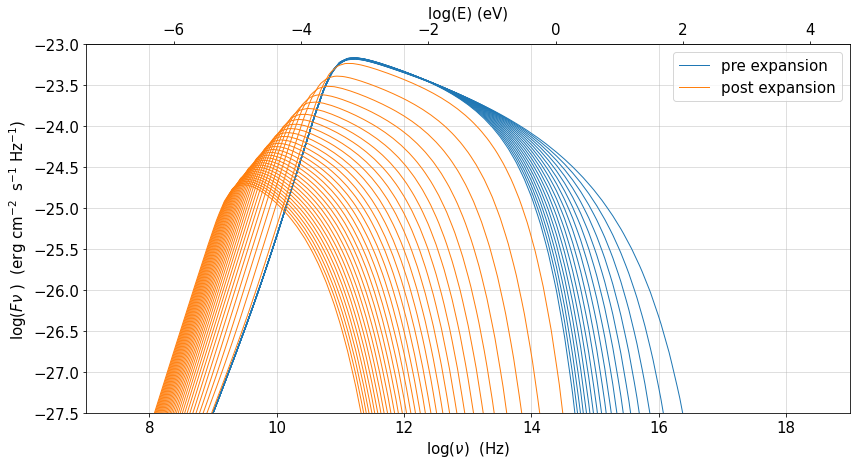

In [26]:
%matplotlib inline
p=PlotSED(frame='obs',density=True)
p.resplot.remove()
skip_label=False
step=int(NUM_SET/50)

for i in range(0,NUM_SET,step):
    
    t=temp_ev_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    if t[0][0]<temp_ev_expansion.parameters.t_jet_exp.val:
        c='C0'
    else:
        c='C1'
    label=None
    if i==0:
        label='pre expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
        label='post expansion'
        skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=True,auto_label=False)
p.rescale(y_min=-27.5,y_max=-23,x_min=7,x_max=19)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


In [27]:
p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


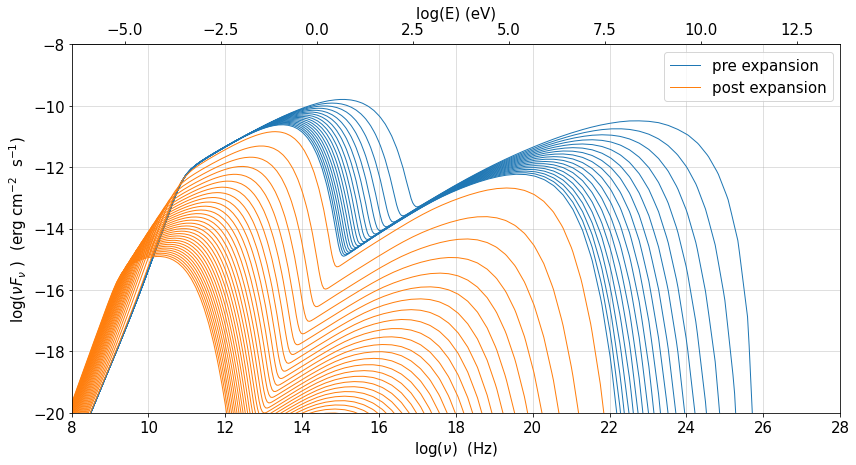

In [28]:
p=PlotSED(frame='obs',density=False)
p.resplot.remove()
skip_label=False

step=int(NUM_SET/50)

for i in  range(0,NUM_SET,step):
    t=temp_ev_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_expansion.rad_region.get_SED(comp='Sum',time_slice=i,frame='obs',use_cached=True)
    s_sync=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)

    if t[0][0]<temp_ev_expansion.parameters.t_jet_exp.val:
        c='C0'
    else:
        c='C1'
    label=None
    if i==0:
        label='pre expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
        label='post expansion'
        skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=False,auto_label=False)

p.rescale(y_min=-20,y_max=-8,x_min=8,x_max=28)

update_sed_plot(p)
p.fig.savefig('temp_ev_sim_exp_vs_no_exp/nuFnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


In [26]:
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')

t_falare=temp_ev_acc_flare.parameters.duration.val


In [27]:
import pickle
with open('temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.100.pkl', 'rb') as f:
    l=pickle.load(f)
l.keys()


dict_keys(['lg_obs', 'lr_obs_5GHz', 'lr_obs_10GHz', 'lr_obs_15GHz', 'lr_obs_20GHz', 'lr_obs_25GHz', 'lr_obs_30GHz', 'lr_obs_35GHz', 'lr_obs_40GHz', 'lr_obs_45GHz', 'lr_obs_50GHz', 'lr_obs_55GHz', 'lr_obs_60GHz', 'lr_obs_65GHz', 'lr_obs_70GHz', 'lr_obs_75GHz', 'lr_obs_80GHz', 'lr_obs_85GHz', 'lr_obs_90GHz', 'lr_obs_95GHz', 'lr_obs_100GHz', 'lr_obs_105GHz', 'lr_obs_110GHz', 'lr_obs_115GHz', 'lr_obs_120GHz', 'lopt_obs', 'lmm_obs', 'lx_obs', 'beta_exp'])

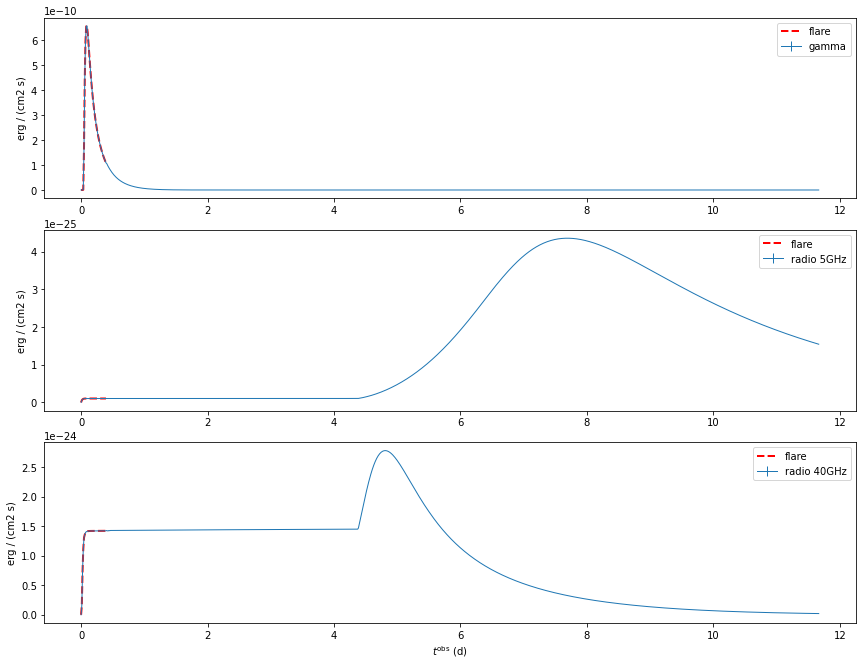

In [28]:
fig=plot_lcs(exp_lcs='temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.100.pkl',lcs_names=['lg_obs','lr_obs_5GHz','lr_obs_40GHz'],flare_lcs='temp_ev_sim_flare/lc_obs_flare.pkl')

In [29]:
t_flare=temp_ev_acc_flare.parameters.duration.val
t_exp_obs_merged_lcs=(t_flare+t_exp*1.03)/temp_ev_expansion.rad_region.jet.parameters.beam_obj.val/86400

Text(26.00312500000001, 0.5, 'erg cm$^{-2}$ s$^{-1}$')

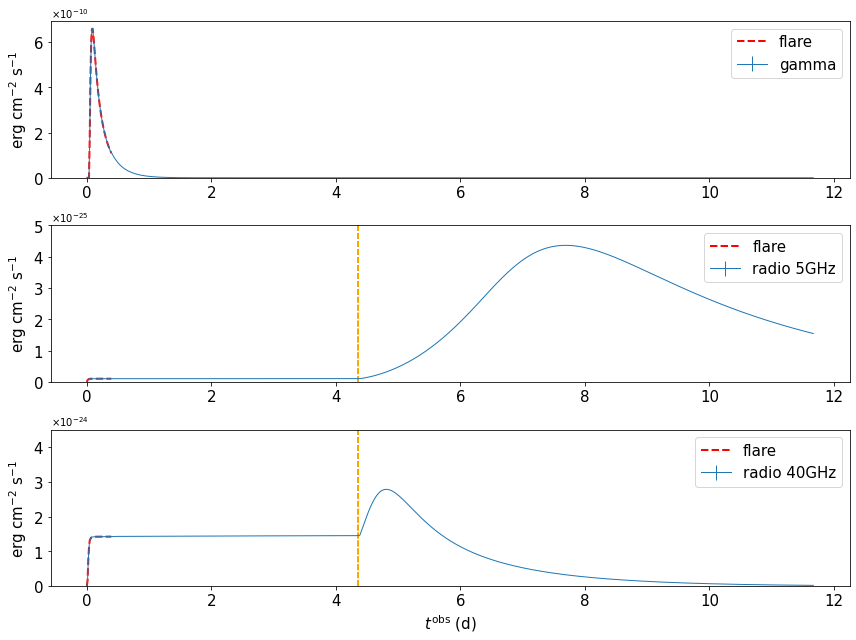

In [34]:
update_lc_plot(fig)
fig.axes[1].axvline(x=t_exp_obs_merged_lcs,ls='--',c='orange')
fig.axes[2].axvline(x=t_exp_obs_merged_lcs,ls='--',c='orange')
fig.axes[0].set_ylim(0,None)
fig.axes[1].set_ylim(0,0.5E-24)
fig.axes[2].set_ylim(0,4.5E-24)
fig.axes[0].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[1].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[2].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')

In [35]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/lc_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)

In [36]:
beta_exp=[0.0]

#delta_t_out=5E3
#average=0.05
#rest_frame='obs'
run=False
for ID,v in enumerate(beta_exp):
    #duration=delta_t_est(t_exp,R0,v)+10*t_dec_est(R0,-1,v)
    duration=delta_t_est(t_exp,R0,0.1)+10*t_dec_est(R0,-1,0.1)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,0.1)/86400))
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(sed_data,
                      fit_model,
                      'temp_ev_sim_exp_vs_no_exp',
                      temp_ev_acc_flare,
                      expansion='off',
                      flare_duration=0,
                      average=None,
                      duration=2.833334e+07,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      t_exp=1E60)
    
   
    print('----------------------------------------------')

ID 0
beta_exp 0.000000
delta_t  est. 1.350309e+02 (d)
T_SIZE 28333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
----------------------------------------------


In [37]:
temp_ev_no_expansion=JetTimeEvol.load_model('temp_ev_sim_exp_vs_no_exp/temp_ev_expansion_beta_exp=0.000.pkl')


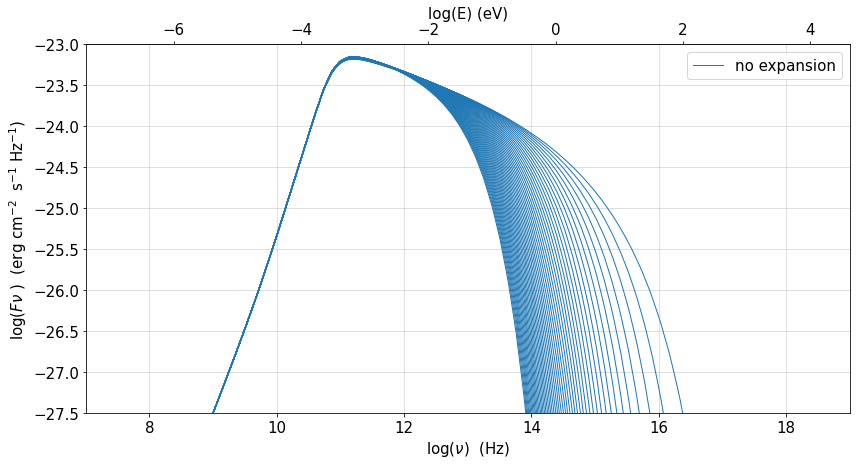

In [38]:
p=PlotSED(frame='obs',density=True)
skip_label=False
p.resplot.remove()
step=int(NUM_SET/50)

for i in range(0,NUM_SET,step):
    t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    #if t[0][0]<temp_ev_expansion.parameters.t_jet_exp.val:
    c='C0'
    #else:
    #    c='g'
    label=None
    if i==0:
        label='no expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    #if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
    #    label='post expansion'
    #    skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=True,auto_label=False)
      
p.rescale(y_min=-27.5,y_max=-23,x_min=7,x_max=19)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0) 

estimate of $\nu_{SSA}^0$

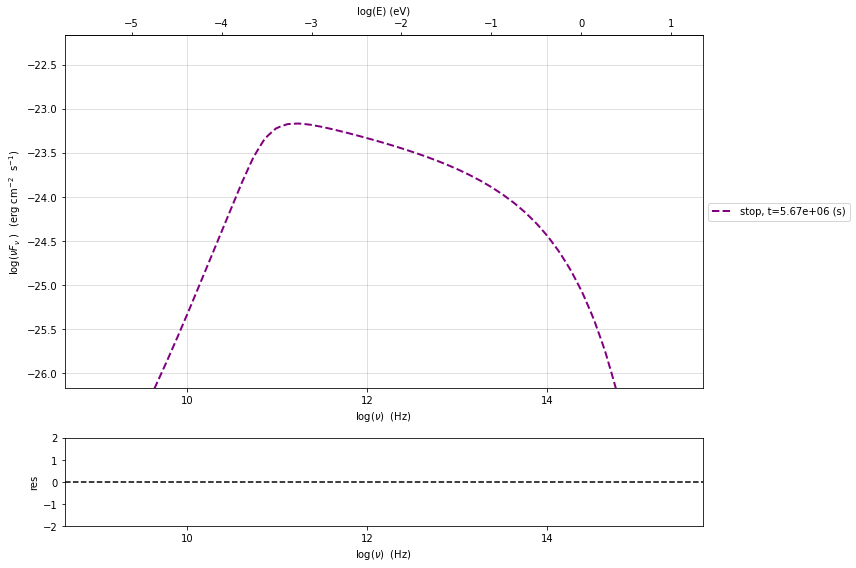

In [42]:
%matplotlib inline
t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=999)
p=temp_ev_no_expansion.plot_tempev_model(density=True,time_slice=999)
s=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=999,frame='obs',use_cached=True)


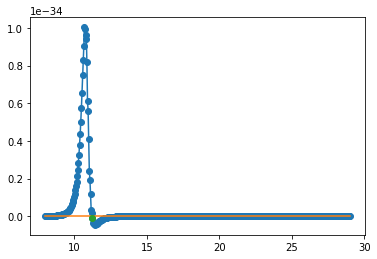

In [43]:
%matplotlib inline
deriv=np.gradient(s.nuFnu.value/s.nu.value,s.nu.value)
plt.plot(np.log10(s.nu.value),deriv,'o-')
plt.plot(np.log10(s.nu.value),np.zeros(s.nu.size))
id_max=np.argmax(s.nuFnu.value/s.nu.value)
nu_ssa_obs=s.nu.value[id_max]
plt.plot(np.log10(nu_ssa_obs),deriv[id_max],'o')

In [44]:
nu_ssa_0_obs_GHz=nu_ssa_obs/1E9
nu_ssa_0_blob_GHz=nu_ssa_0_obs_GHz/temp_ev_no_expansion.rad_region.jet.parameters.beam_obj.val
print('nu_ssa_0_obs_GHz',nu_ssa_0_obs_GHz)
print('nu_ssa_0_blob_GHz',nu_ssa_0_blob_GHz)

nu_ssa_0_obs_GHz 173.9726432343799
nu_ssa_0_blob_GHz 5.799088107812663


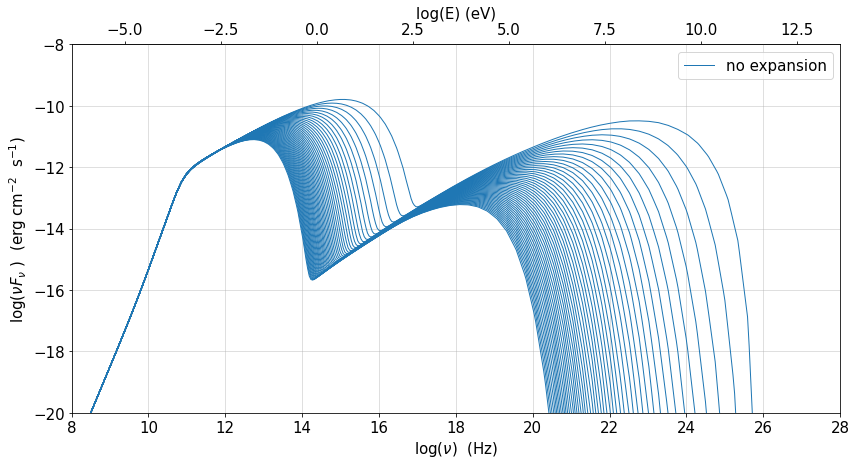

In [45]:
%matplotlib inline
p=PlotSED(frame='obs',density=False)
skip_label=False
p.resplot.remove()

step=int(NUM_SET/50)

for ID,i in enumerate(range(0,NUM_SET,step)):
    t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_no_expansion.rad_region.get_SED(comp='Sum',time_slice=i,frame='obs',use_cached=True)
    s_sync=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_no_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
   
    c='C0'
    #else:
    #    c='g'
    label=None
    if i==0:
        label='no expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    #if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
    #    label='post expansion'
    #    skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=False,auto_label=False)
      
p.rescale(y_min=-20,y_max=-8,x_min=8,x_max=28)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/nuFnu_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0) 

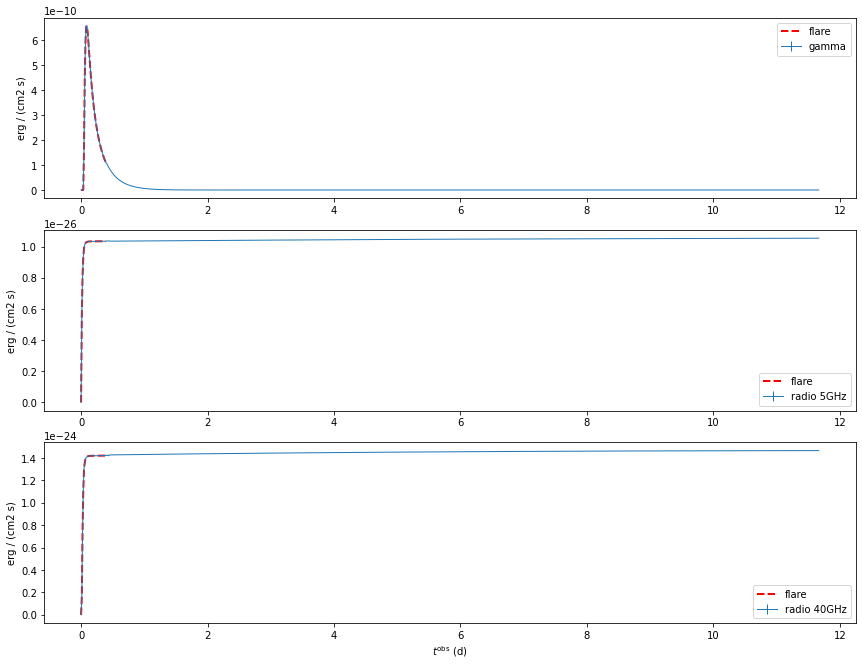

In [39]:
fig=plot_lcs(exp_lcs='temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.000.pkl',lcs_names=['lg_obs','lr_obs_5GHz','lr_obs_40GHz'],flare_lcs='temp_ev_sim_flare/lc_obs_flare.pkl')

In [40]:
fig.axes[0].set_ylim(0,None)
fig.axes[1].set_ylim(0,0.5E-24)
fig.axes[2].set_ylim(0,4.5E-24)
fig.axes[0].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[1].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[2].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')

Text(17.200000000000003, 0.5, 'erg cm$^{-2}$ s$^{-1}$')

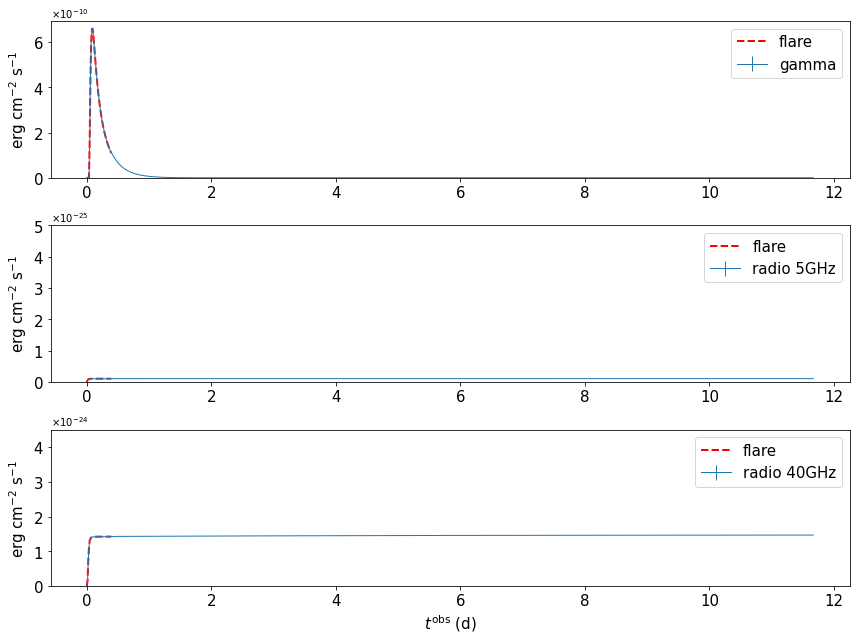

In [41]:
update_lc_plot(fig)


In [42]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/lc_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0)

In [50]:
step=1
N=len(range(0,NUM_SET,step))
y_p_S_exp=np.zeros(N)
y_p_IC_exp=np.zeros(N)
y_p_S_no_exp=np.zeros(N)
y_p_IC_no_exp=np.zeros(N)
T_IC_dom=np.zeros(N)
for ID,i in enumerate(range(0,NUM_SET,step)):
    T_IC_dom[ID]=temp_ev_expansion.rad_region.time_sampled_emitters.time_obs[i]
    s_sync=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
    y_p_S_exp[ID]=s_sync.nuFnu.max().value
    y_p_IC_exp[ID]=s_IC.nuFnu.max().value
    
    s_sync=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_no_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
    y_p_S_no_exp[ID]=s_sync.nuFnu.max().value
    y_p_IC_no_exp[ID]=s_IC.nuFnu.max().value
    

In [51]:
t_exp_obs_CD=(t_exp*1.03)/temp_ev_expansion.rad_region.jet.parameters.beam_obj.val/86400

ticklabel_format failed


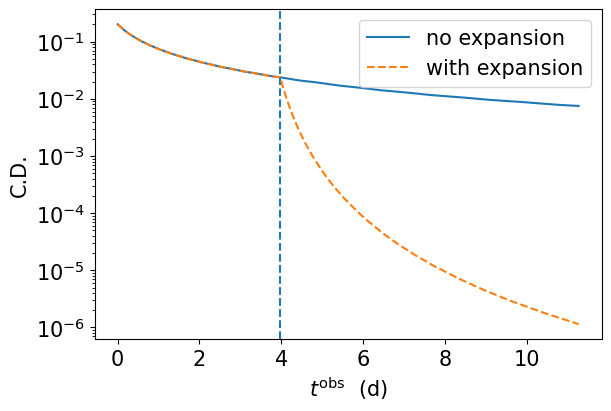

In [52]:
fig = plt.figure(constrained_layout=True,dpi=100)
ax=fig.add_subplot()
ax.axvline(x=t_exp_obs_CD,ls='--')
ax.semilogy(T_IC_dom/86400,y_p_IC_no_exp/y_p_S_no_exp,label='no expansion')
ax.semilogy(T_IC_dom/86400,y_p_IC_exp/y_p_S_exp,label='with expansion',ls='--')
ax.set_xlabel(r'$t^{\rm obs}$  (d)')
ax.set_ylabel('C.D.')
ax.legend(loc='best')
updage_fig(fig)

In [148]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/CD_evolution.pdf',bbox_inches = 'tight',
    pad_inches = 0)